In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from nbodykit.lab import *
from nbodykit import style, setup_logging
from pmesh.pm import ParticleMesh

import matplotlib.pyplot as plt
plt.style.use(style.notebook)
# turn on logging to screen



<h2>
Initialise nbodykit dark matter sim 
</h2>

In [2]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

BoxSize=1380
nbar=3e-3
bias=1.0
seed=42
cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=BoxSize, Nmesh=256, bias=1.0, seed=42)

In [3]:
mesh = cat.to_mesh(resampler='tsc')

In [4]:
one_plus_delta = mesh.paint(mode='real')
print(type(one_plus_delta))

<class 'pmesh.pm.RealField'>


In [5]:
print("mean of 1+delta = ", one_plus_delta.value.mean())
print("min of 1+delta = ", one_plus_delta.value.min())
print("max of 1+delta = ", one_plus_delta.value.max())


mean of 1+delta =  1.0000004
min of 1+delta =  0.0
max of 1+delta =  18.71194


Text(0.5, 1.0, 'Slice of Density Field')

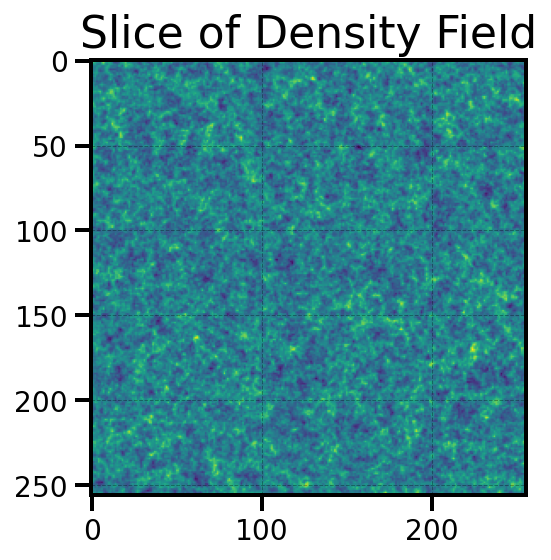

In [6]:
plt.imshow(one_plus_delta.preview(axes=[0,1]))
plt.title("Slice of Density Field")

(0.01, 20)

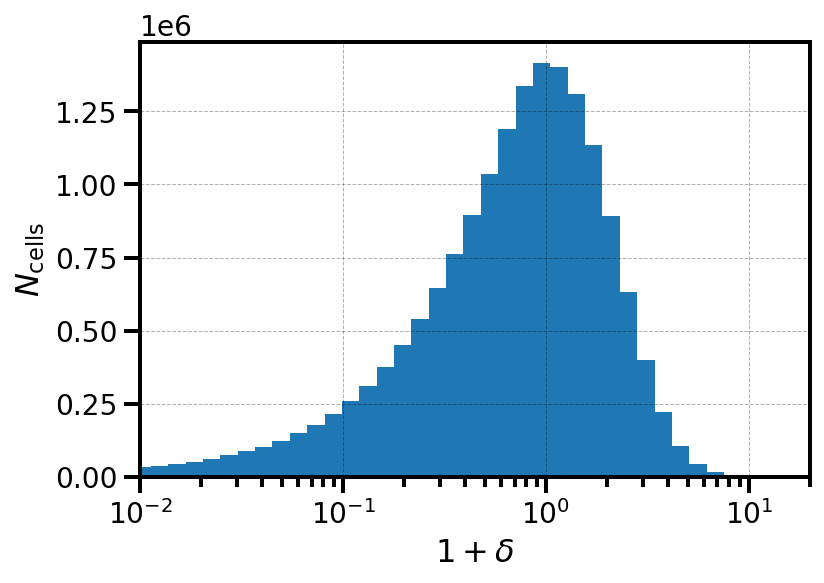

In [7]:
# histogram of 1+delta in log-spaced bins
bins = numpy.logspace(-7, numpy.log10(30.), 100)
_ = plt.hist(one_plus_delta.value.flatten(), bins=bins)

# format the axes
plt.xscale('log')
plt.xlabel(r"$1+\delta$")
plt.ylabel(r"$N_\mathrm{cells}$")
plt.xlim(1e-2, 20)

In [8]:
cat.view()

LogNormalCatalog(seed=42, bias=1)

In [9]:
mesh.preview()

array([[[1.2475644 , 1.2820683 , 1.1809564 , ..., 2.6298754 ,
         2.6268272 , 0.7212909 ],
        [1.8329061 , 2.6995778 , 2.7282238 , ..., 1.2634276 ,
         1.5865163 , 1.359379  ],
        [1.0244024 , 2.449019  , 2.9146717 , ..., 0.03518133,
         0.29716805, 0.7652241 ],
        ...,
        [0.01022511, 0.22078273, 0.22430472, ..., 0.24279423,
         0.5054813 , 0.31486142],
        [0.03692134, 0.0304927 , 0.8003158 , ..., 1.3505259 ,
         0.6804314 , 0.8232082 ],
        [0.22242044, 0.18286589, 0.8590312 , ..., 1.3300787 ,
         1.3617415 , 1.270586  ]],

       [[0.534694  , 0.7766458 , 0.72955245, ..., 2.7769957 ,
         1.5087223 , 0.28900382],
        [0.4301562 , 0.73970586, 1.4811642 , ..., 1.6895525 ,
         2.2439194 , 0.49298567],
        [0.12246174, 0.38748422, 1.4889287 , ..., 0.6985571 ,
         1.8160231 , 0.34801564],
        ...,
        [0.12398608, 0.64122164, 0.5284641 , ..., 0.3934303 ,
         0.07151615, 0.24093921],
        [0.3

In [10]:
#Begin tidal calculations


In [11]:
import sys
import os
from mpi4py import MPI
import numpy as np
from pmesh.pm import ParticleMesh
from absl import app
from absl import flags
from astropy.io import fits


#Define Flags
#Mostly artefacts from previous library, however held onto for future prosperity

FLAGS = flags.FLAGS

flags.DEFINE_string("snapshot",
                    "/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/Outer_snapshots/z1.01/m000.mpicosmo.247",
                    "Path to the GenericIO snapshot file.")
flags.DEFINE_string("galaxy_positions",
                    "/global/cscratch1/sd/flanusse/pos_247.fits",
                    "Path to galaxy positions")
flags.DEFINE_string("output_dir",
                    "/global/cscratch1/sd/flanusse",
                    "Output directory to save the  tidal field information.")
flags.DEFINE_integer("mesh_size", 256,
                     "Size of the mesh on which the tidal field is computed.")
flags.DEFINE_float("smoothing_scale", 1.0,
                   "Smoothing scale for Gaussian low pass filter, in Mpc/h")



In [12]:
#Parallel communicator
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nranks = comm.Get_size()

In [13]:
print(nranks)

1


In [14]:
def lowpass_transfer(r):
  """
  Filter for smoothing the field
  """
  def filter(k, v):
    k2 = sum(ki ** 2 for ki in k)
    return np.exp(-0.5 * k2 * r**2) * v
  return filter

def tidal_transfer(d1, d2):
  """
  Filter to compute the tidal tensor
  """
  def filter(k, v):
    k2 = sum(ki ** 2 for ki in k)
    k2[k2 == 0] = 1.0
    C1 = (v.BoxSize / v.Nmesh)[d1]
    w1 = k[d1] * C1

    C2 = (v.BoxSize / v.Nmesh)[d2]
    w2 = k[d2] * C2
    return w1 * w2 / k2 * v
  return filter

In [15]:
def calculate(mesh):
  # Instantiate mesh
  pm =  ParticleMesh(BoxSize=BoxSize, # assuming cube
                     Nmesh=[256]*3,
                     dtype='f8',
                     comm=comm)
  # Extract particle positions of original mesh
  pos = np.array(mesh.Position)

  # Create domain decomposition for the particles that matches the mesh
  layout = pm.decompose(pos) #For parallel computations

  # Create a mesh
  rho = pm.create('real')

  # Paint the particles on the mesh
  rho.paint(pos, layout=layout, hold=False)
  print('Density painted')

  rho1 = rho
  # Compute density and forward FFT
  N = pm.comm.allreduce(len(pos))
  fac = 1.0 * pm.Nmesh.prod() / N
  rho[...] *= fac
  rhok = rho.r2c()
  rhok = rhok.apply(lowpass_transfer(r=1.0))
  print('Rho computed')
  rho2 = rhok.c2r()
  # Create mock galaxy positions
  x = np.linspace(0, BoxSize, 256)
  y = np.linspace(0, BoxSize, 256)
  z = np.linspace(0,BoxSize, 256)
    
  xv, yv, zv = np.meshgrid(x, y, z)
  gal_pos = np.stack([xv.reshape((-1,)),yv.reshape((-1,)),zv.reshape((-1,))], axis=-1)

  # Computing the distribution of galaxies in the cube
  layout_gal = pm.decompose(gal_pos)
  gal_pos = layout_gal.exchange(gal_pos)

  # Retrieve local density on each galaxy
  density = rhok.c2r().readout(gal_pos)
  density = layout_gal.gather(density, mode='all')
 # if rank == 0:
 #   fits.writeto(FLAGS.output_dir+'/density_247.fits', density, overwrite=True)

  #Do tidal calculations  
  tidal_tensors = []
  for i in range(3):
    tidal_tensors.append(np.stack([rhok.apply(tidal_transfer(j, i)).c2r().readout(gal_pos) for j in range(3)], axis=-1))
  tidal_tensors = np.stack(tidal_tensors, axis=-1)

  # At this point, tidal_tensor in each rank contains the tensor for the local
  # galaxies
  # Now computing diagonalization
  vals, vects = np.linalg.eigh(tidal_tensors)

  # Retrieving the computed values
  vals = layout_gal.gather(vals, mode='all')
  vects = layout_gal.gather(vects, mode='all')

  return density, vals, vects, rho1, rho2
  #if rank == 0:
  #  fits.writeto(FLAGS.output_dir+'/tidal_val_247.fits', vals, overwrite=True)
  #  fits.writeto(FLAGS.output_dir+'/tidal_vects_247.fits', vects, overwrite=True)



In [16]:
#The following are temporary functions to test portions of above functions
pm =  ParticleMesh(BoxSize=BoxSize, # assuming cube
                     Nmesh=[256]*3,
                     dtype='f8',
                     comm=comm)


In [17]:
x = np.linspace(0, BoxSize, 256)
y = np.linspace(0, BoxSize, 256)
z = np.linspace(0,BoxSize, 256)
xv, yv, zv = np.meshgrid(x, y, z)

In [18]:
coords = np.stack([xv.reshape((-1,)),yv.reshape((-1,)),zv.reshape((-1,))], axis=-1)

In [19]:
coords.shape

(16777216, 3)

In [20]:
#Test function and plot results

In [21]:
result = calculate(mesh)

/home/matt/anaconda3/envs/TIN-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Use ParticleMesh.paint instead


Density painted
Rho computed


In [22]:
cube = result[0]

In [23]:
cube = cube.reshape([256,256,256])

In [24]:
result

(array([1.80957006, 1.39347746, 1.12444651, ..., 2.72930303, 0.45029162,
        1.80957006]), array([[ -3.27321195,   2.33460544,  24.46377179],
        [ -6.04204104,   6.25585021,  11.22018853],
        [-12.76224652,  -4.76752078,  21.14603834],
        ...,
        [ -4.97822918,  12.71185253,  42.51791294],
        [-26.35886476,  -7.08738637,  17.4723645 ],
        [ -3.27321195,   2.33460544,  24.46377179]]), array([[[-0.41248584,  0.90769459, -0.07711011],
         [ 0.42075375,  0.11475728, -0.89988724],
         [ 0.80797383,  0.40363511,  0.42925166]],
 
        [[-0.66679916,  0.24471186,  0.70391405],
         [-0.00317103,  0.94360978, -0.3310446 ],
         [-0.74523072, -0.2229724 , -0.62842222]],
 
        [[-0.52479613,  0.57927213, -0.62372496],
         [-0.85003341, -0.31782471,  0.4200365 ],
         [ 0.04508024,  0.75062058,  0.65919384]],
 
        ...,
 
        [[ 0.81786359, -0.27881621, -0.50334945],
         [ 0.40975715, -0.33193589,  0.84965737],
      

Text(0.5, 1.0, 'Slice of Real Field Density')

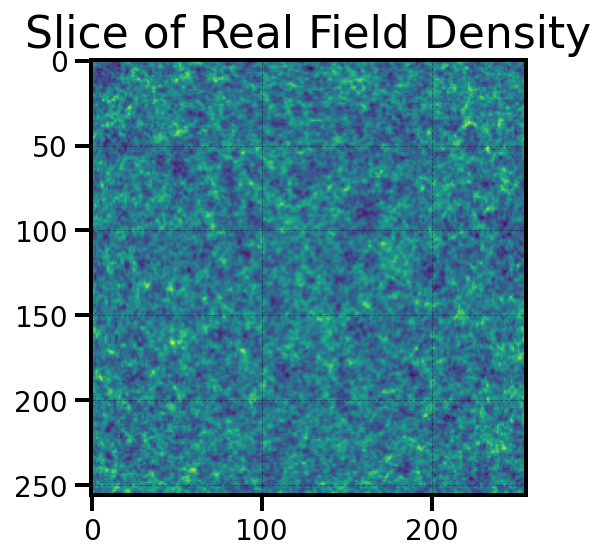

In [25]:
plt.imshow(cube.sum(axis=0))
plt.title("Slice of Real Field Density")

In [26]:
result[1].shape

(16777216, 3)

In [27]:
eigs = result[1].reshape([256,256,256,3])

In [28]:
eigs[:,:,:,0].shape

(256, 256, 256)

Text(0.5, 1.0, 'Slice of First Eigenvalues of Tidal Field')

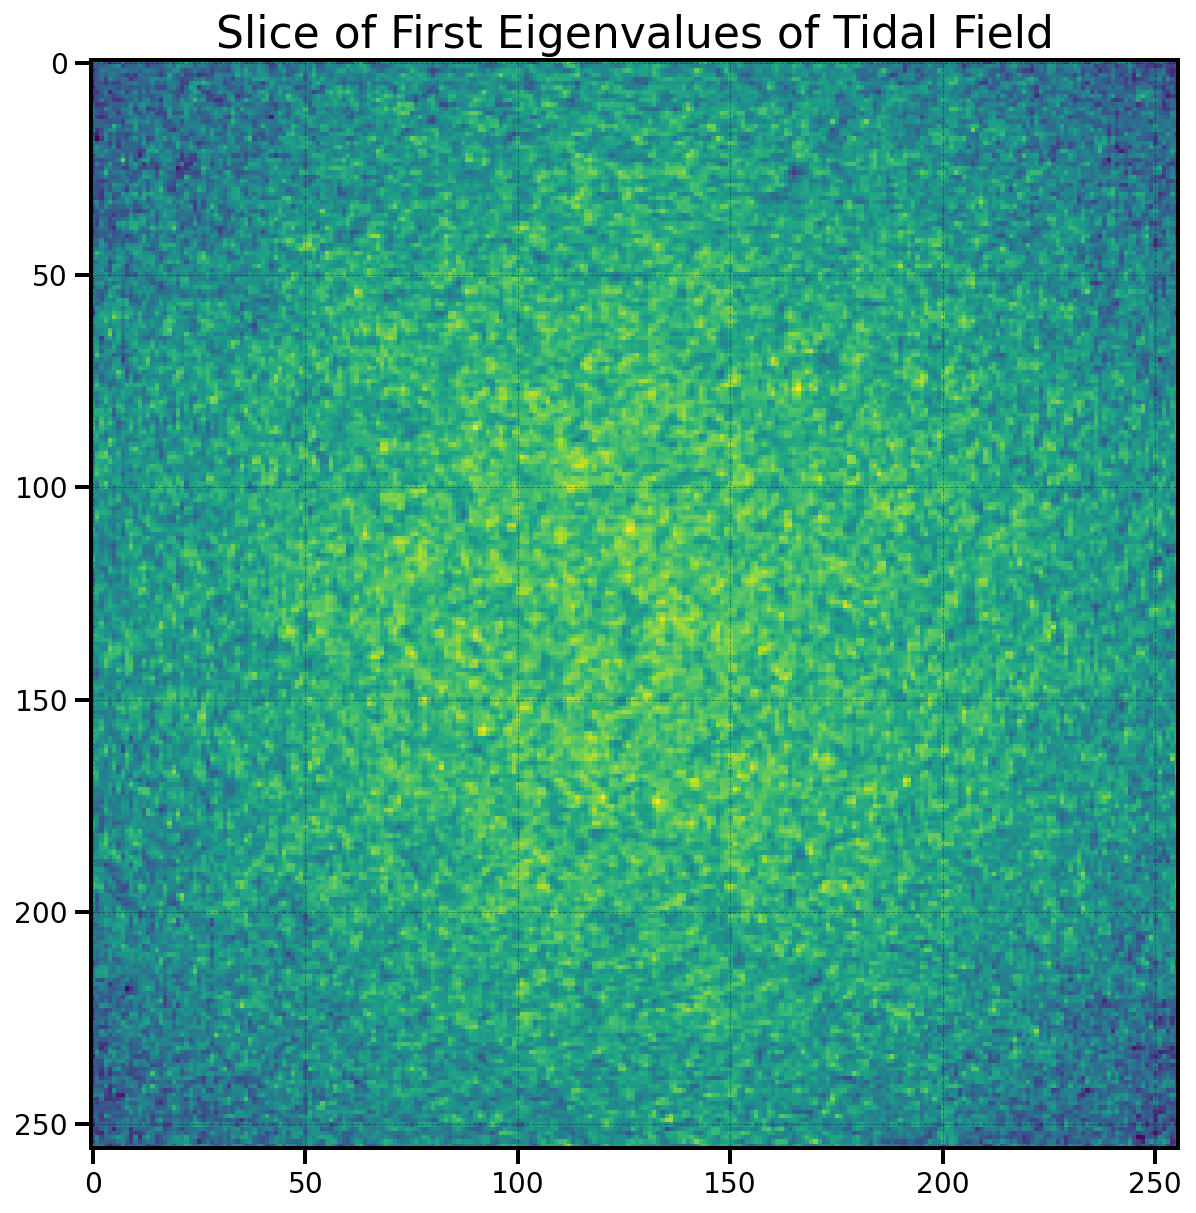

In [29]:
plt.figure(figsize = (10,10))
plt.imshow(eigs[:,:,:,0].sum(axis=0))
plt.title("Slice of First Eigenvalues of Tidal Field")

In [30]:
result[2].shape

(16777216, 3, 3)

In [31]:
vects =  result[2].reshape([256,256,256,3,3])

Text(0.5, 1.0, 'Slice of Tidal Force Vectors')

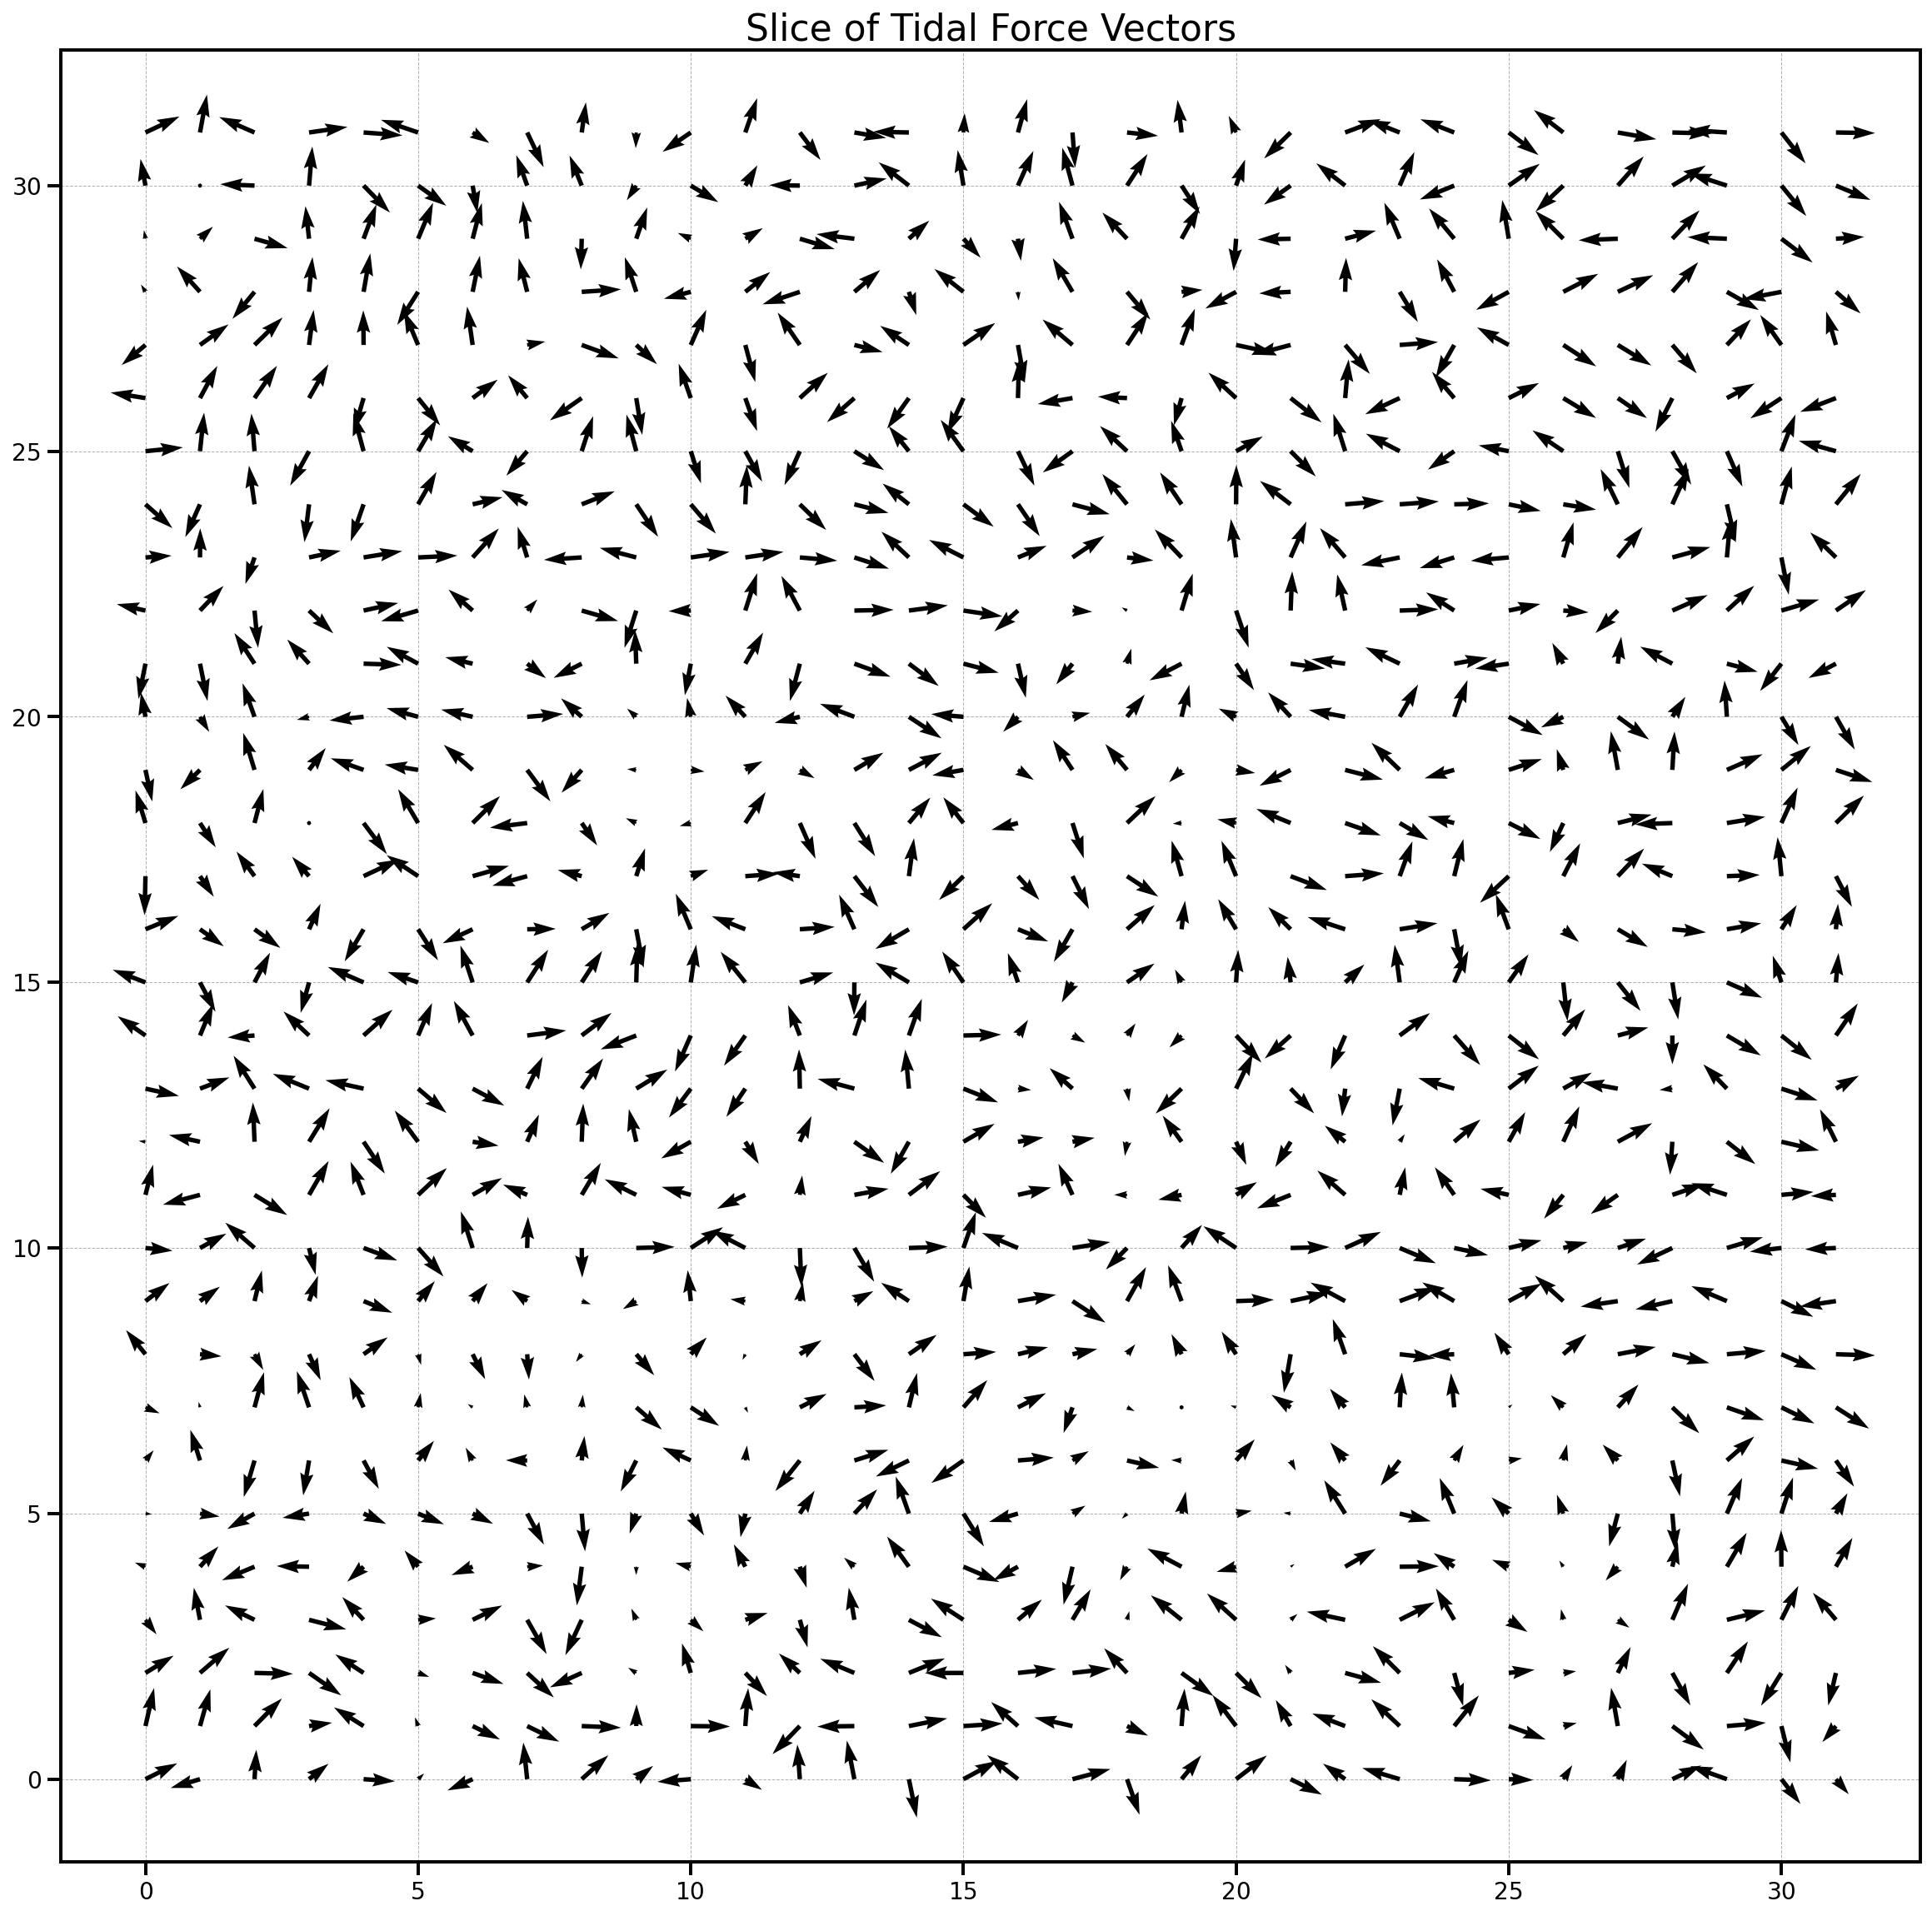

In [32]:
coords3d = coords.reshape((256,256,256,3))
plt.figure(figsize = (20,20))
plt.quiver(
          vects[0,0:32,0:32,2,0],
          vects[0,0:32,0:32,2,1])
plt.title("Slice of Tidal Force Vectors")


Text(0.5, 1.0, 'Tidal Force Vectors against Matter Density Field')

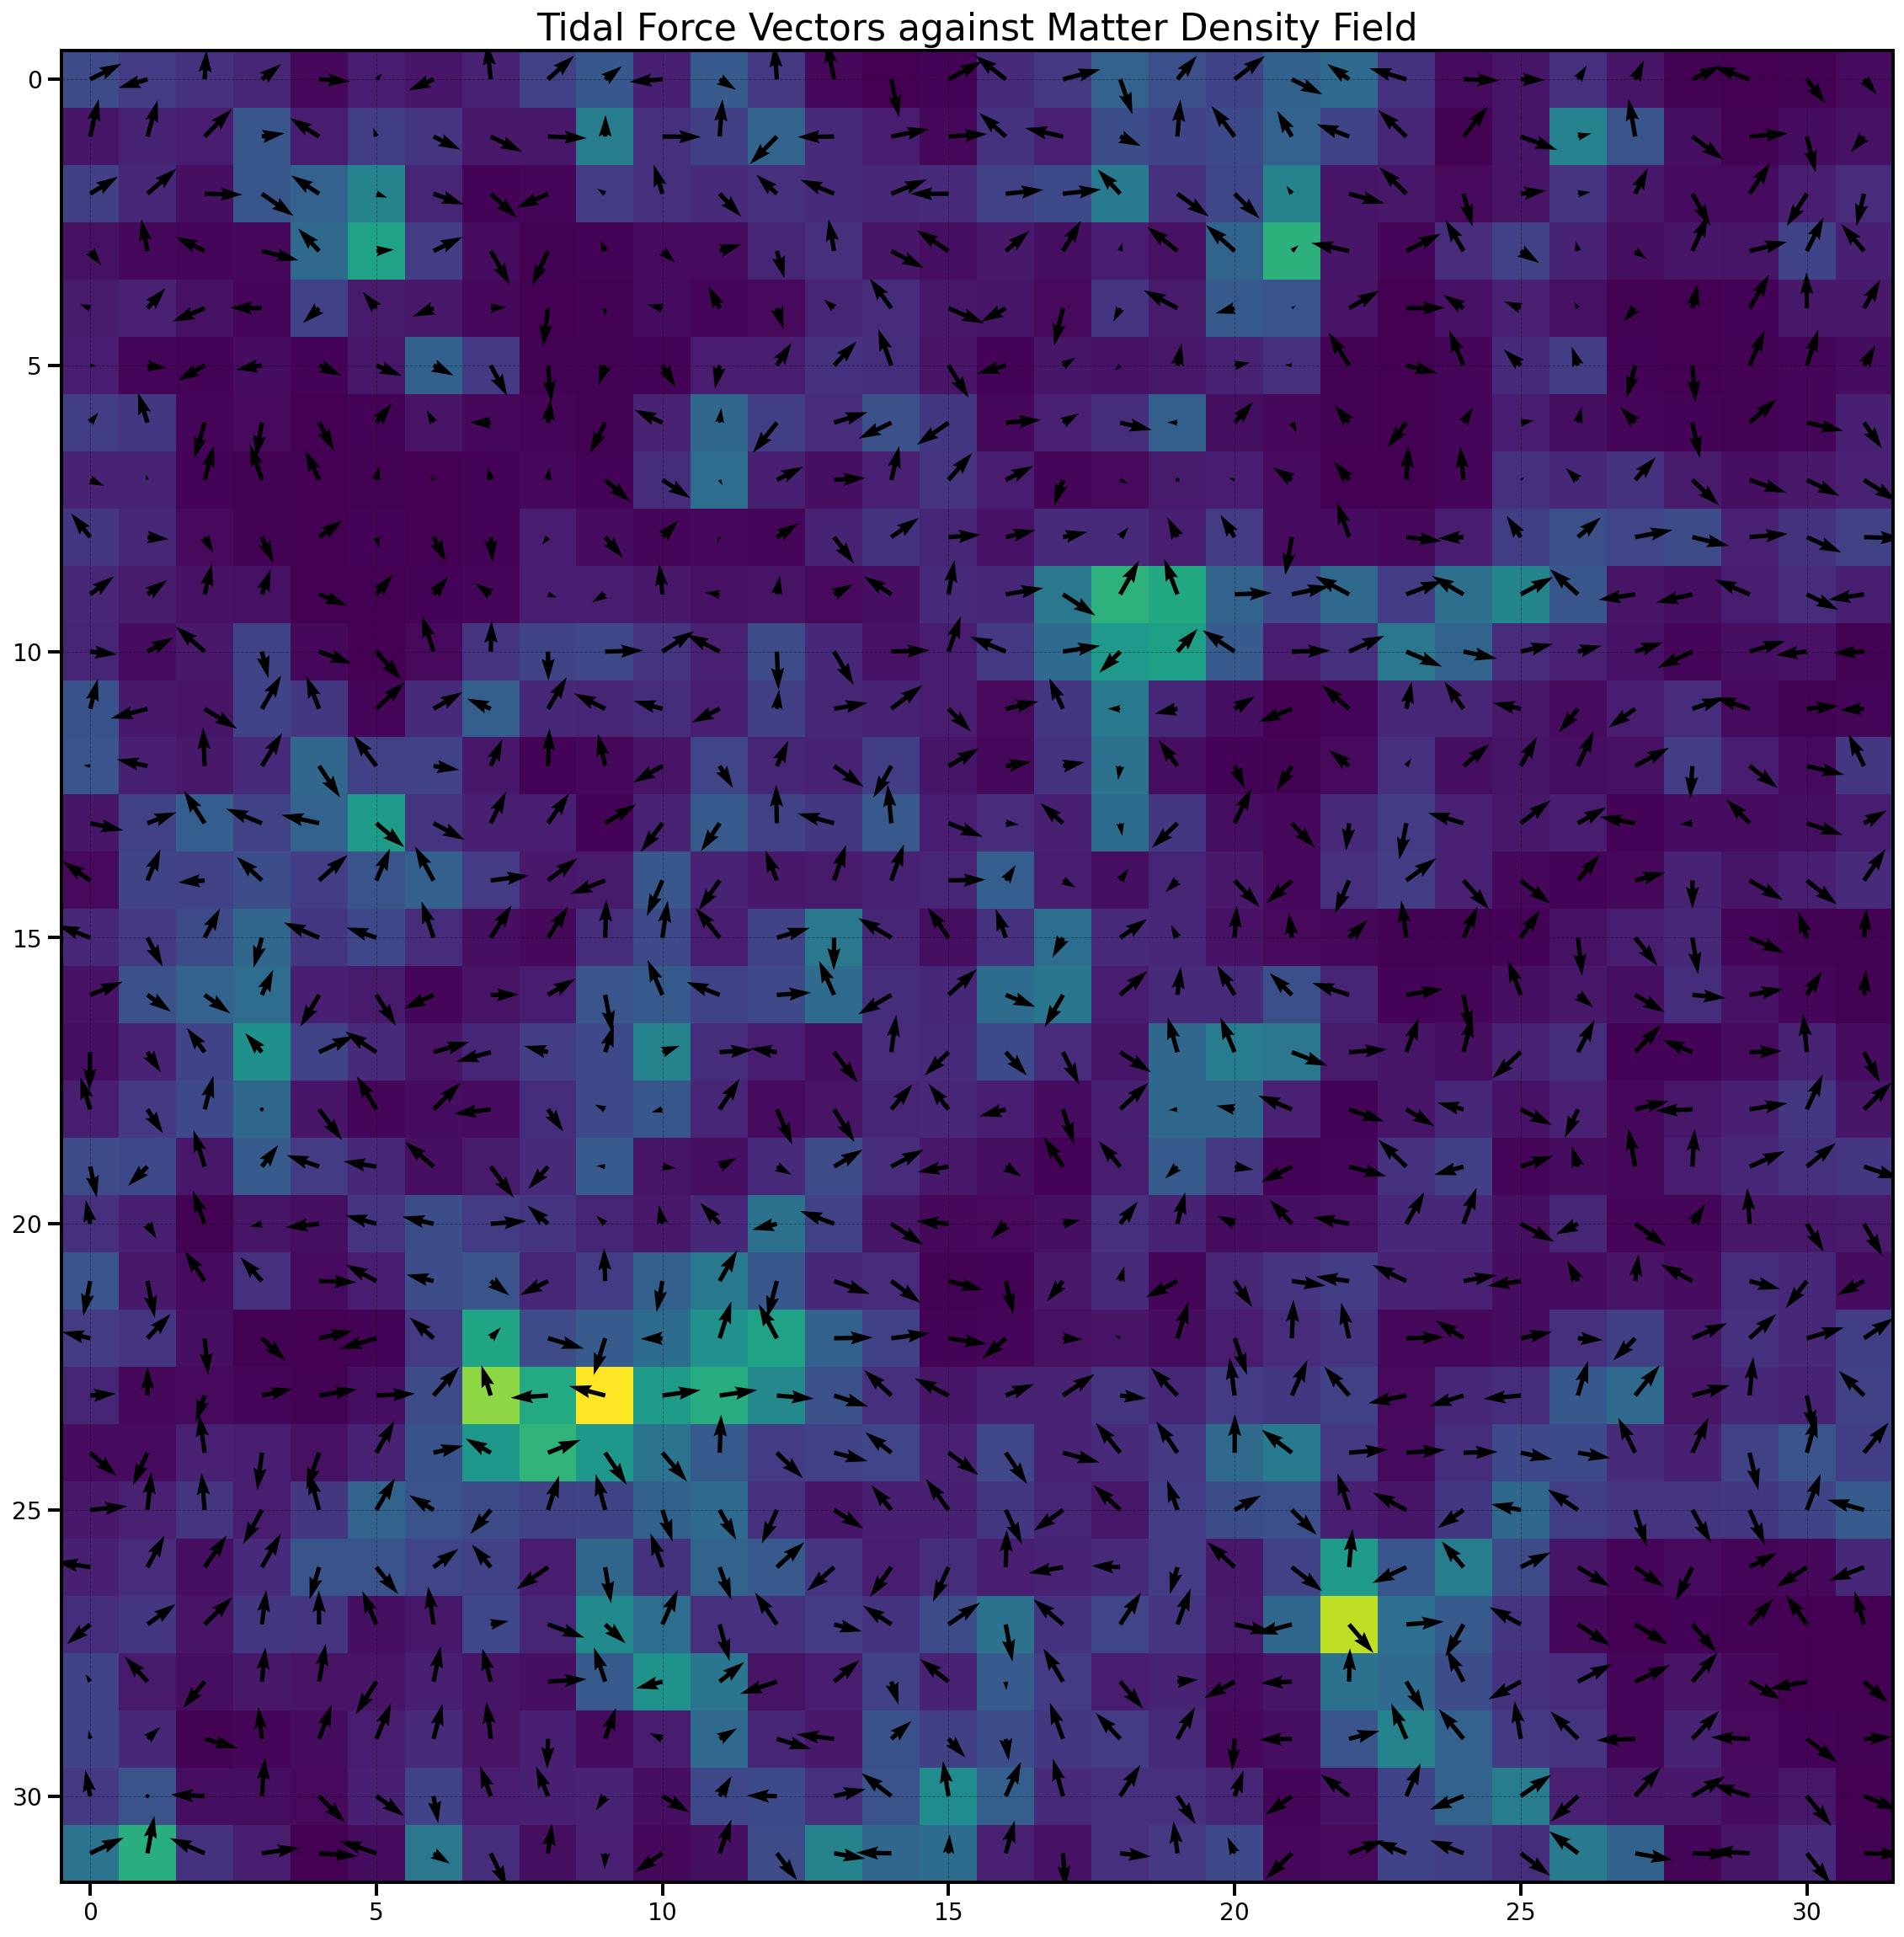

In [33]:
plt.figure(figsize = (20,20))

plt.quiver(
          vects[0,0:32,0:32,2,0],
          vects[0,0:32,0:32,2,1])
plt.imshow(cube[0,0:32,0:32])
plt.show
plt.title("Tidal Force Vectors against Matter Density Field")

<function matplotlib.pyplot.show>

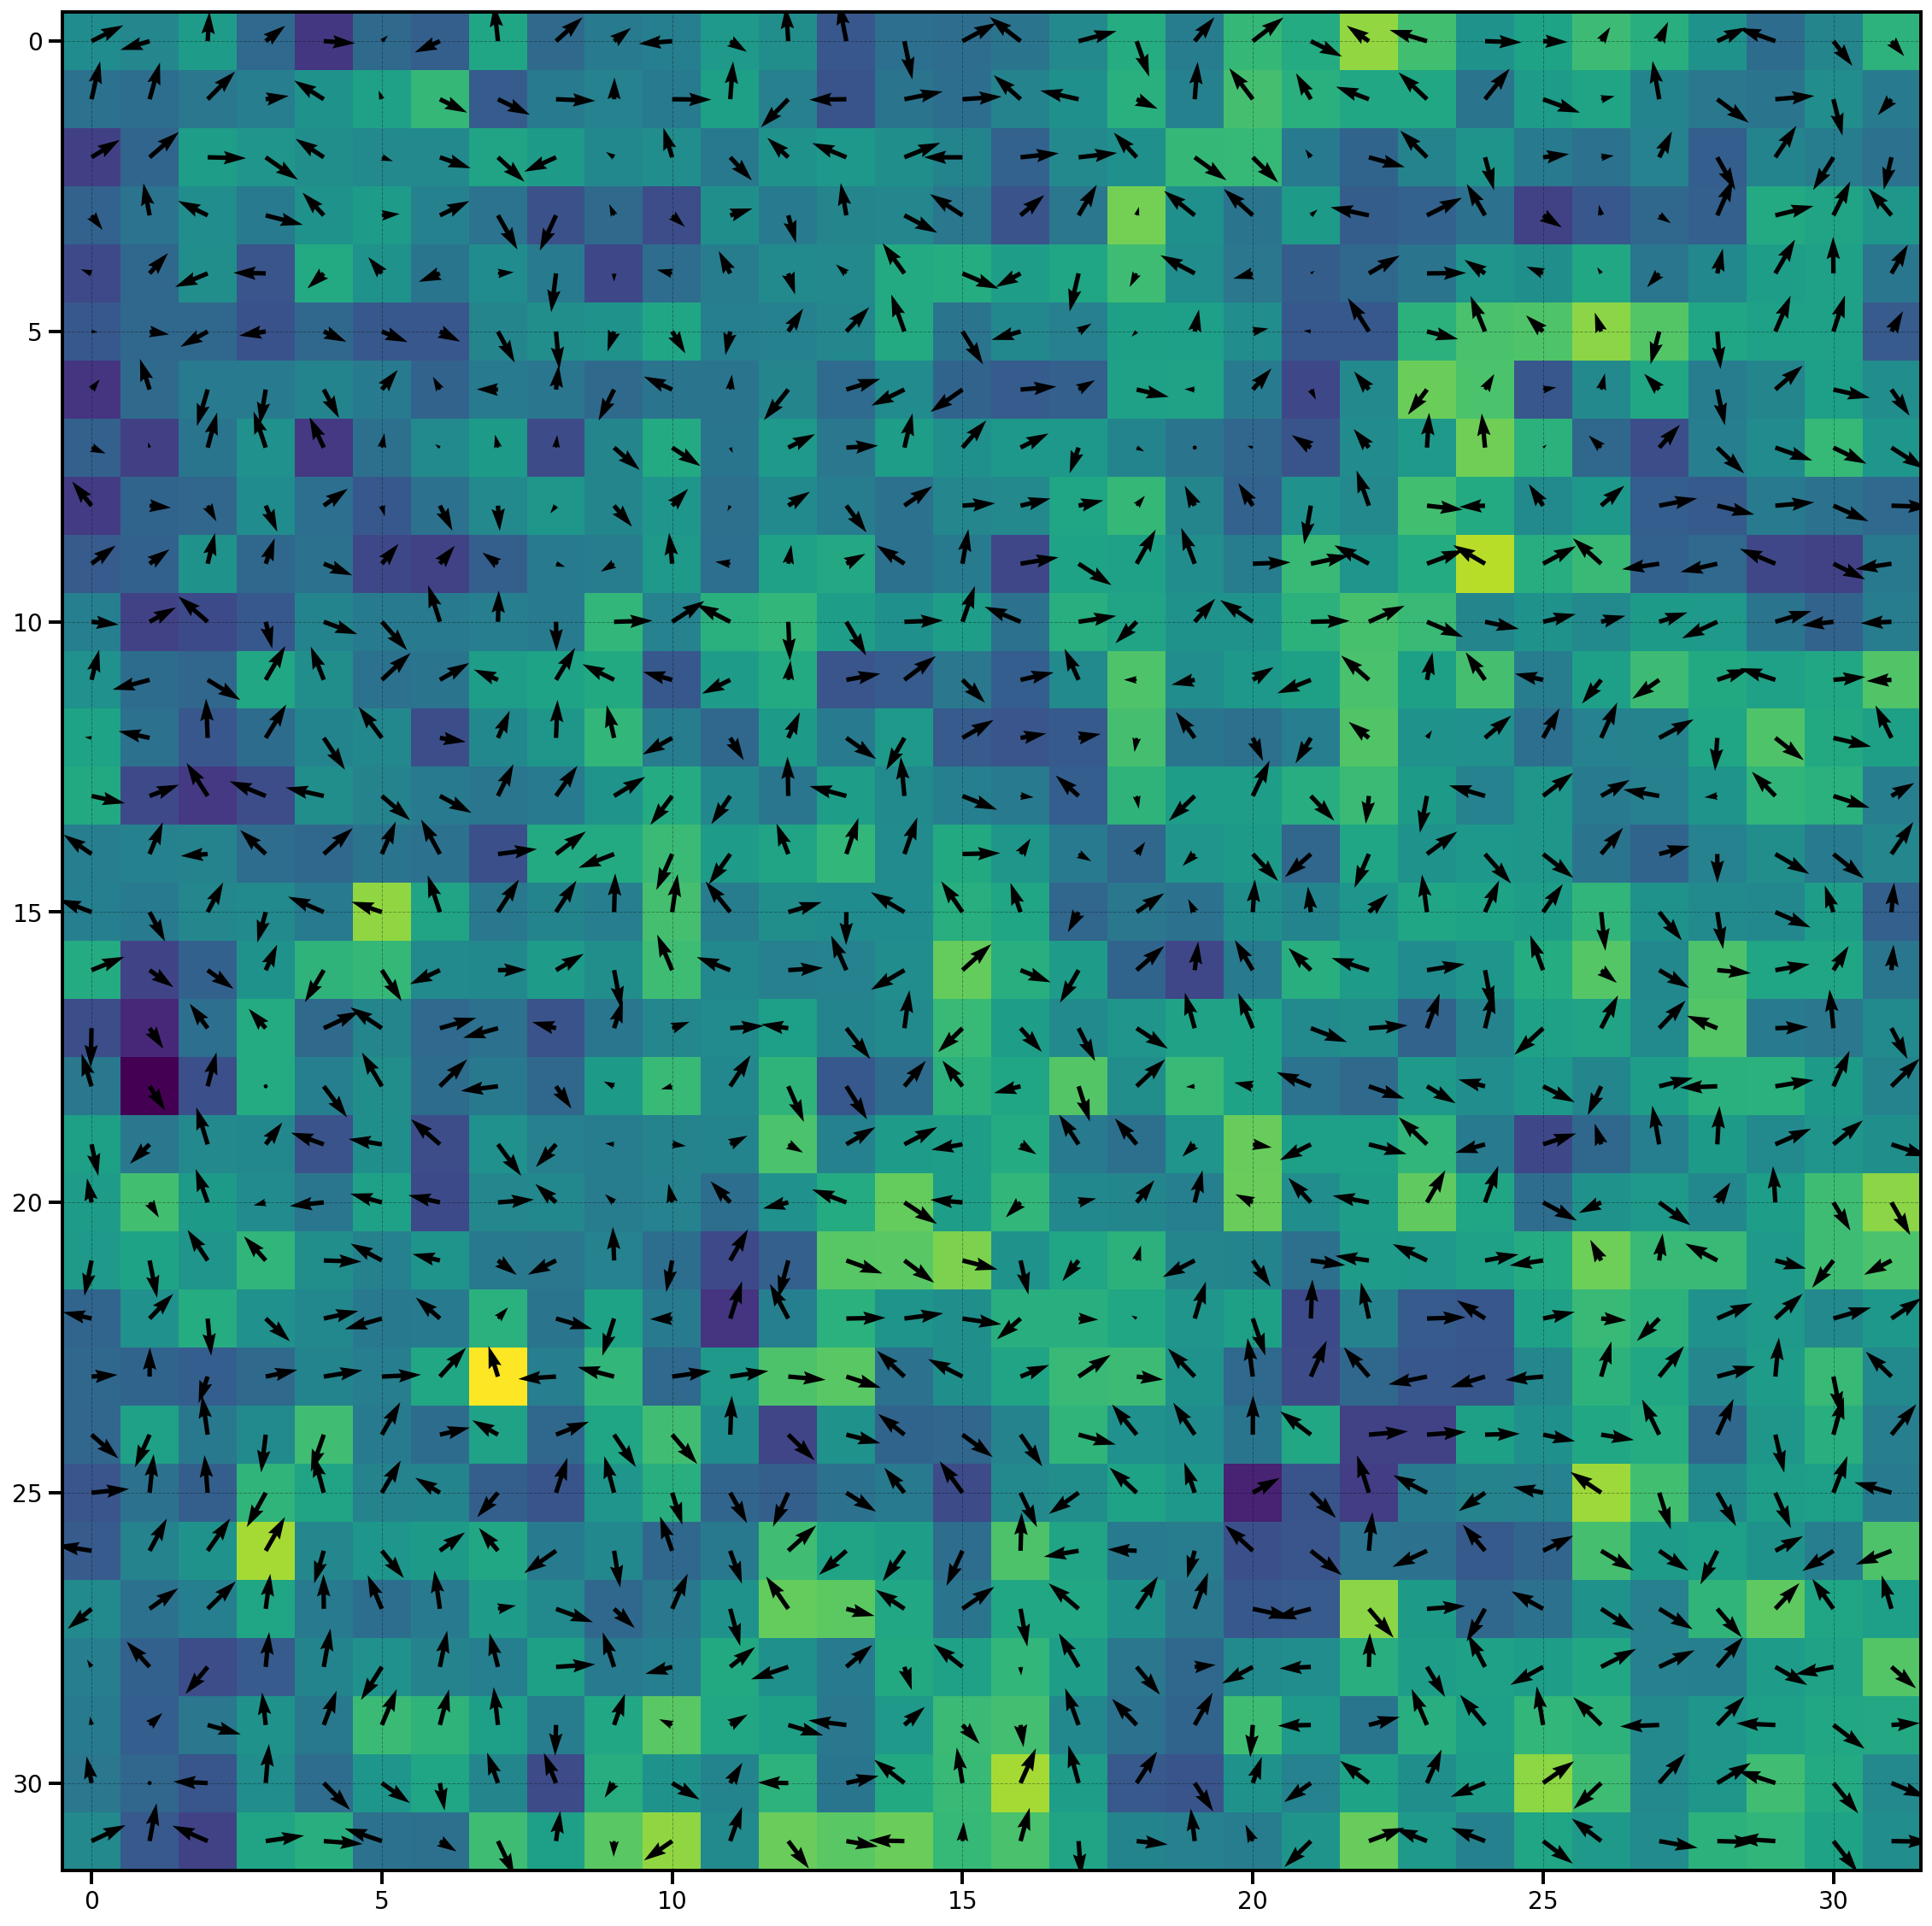

In [34]:
plt.figure(figsize = (20,20))

plt.quiver(
          vects[0,0:32,0:32,2,0],
          vects[0,0:32,0:32,2,1])
plt.imshow(eigs[:,0:32,0:32,0].sum(axis=0))
plt.show

In [35]:
rho = result[3]
rho2 = result[4]

Text(0.5, 0.98, 'Real field before (left) and after (right) lowpass filtering')

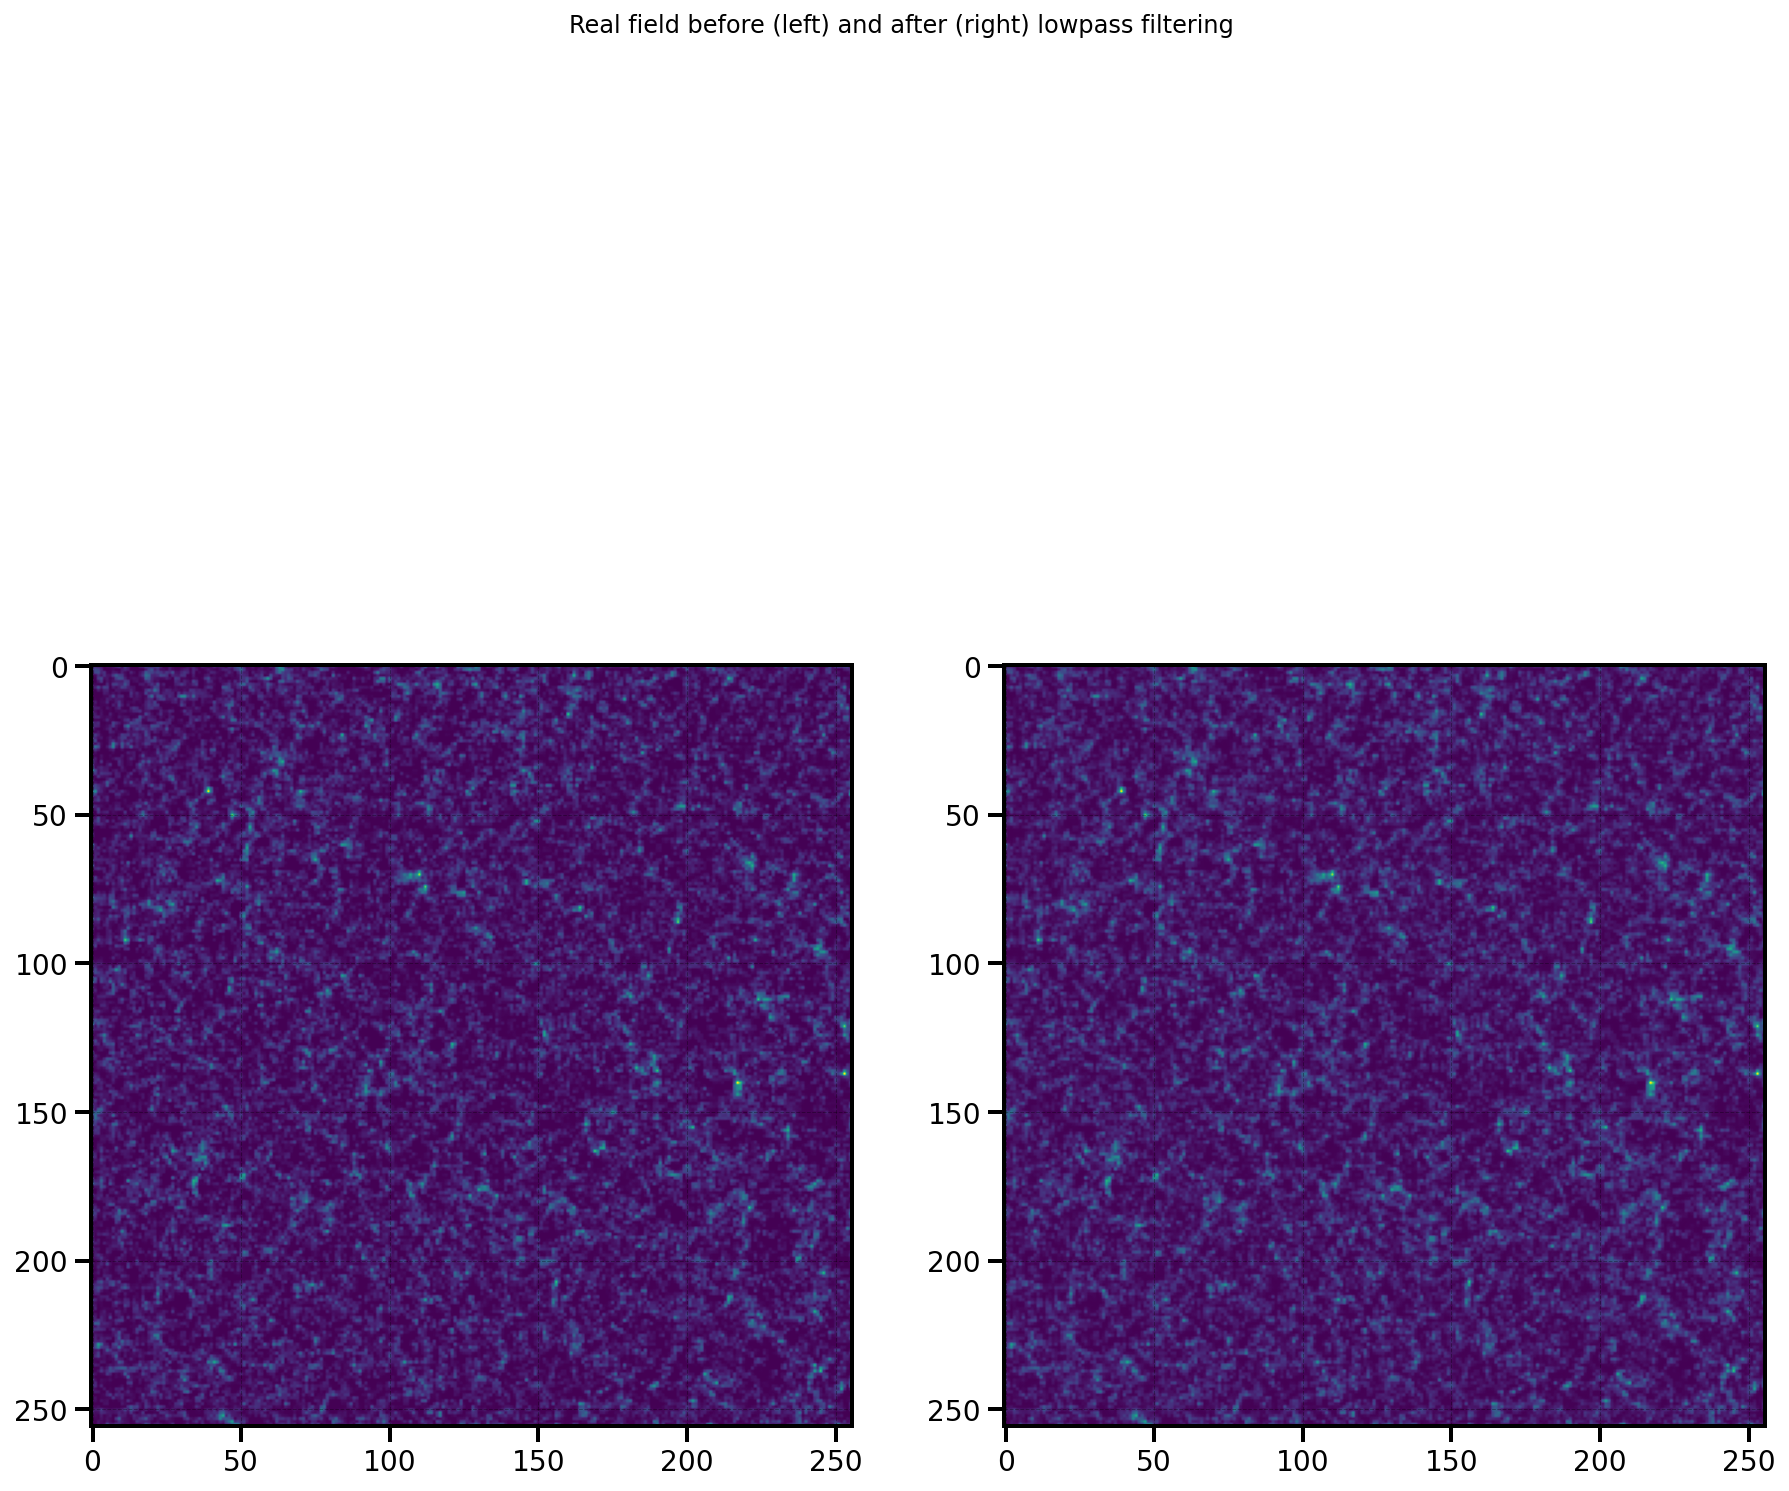

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
#plt.title("Real field before (left) and after (right) lowpass filtering",loc='center')
ax1.imshow(rho[0])
ax2.imshow(rho2[0])
fig.suptitle("Real field before (left) and after (right) lowpass filtering")



<function matplotlib.pyplot.show>

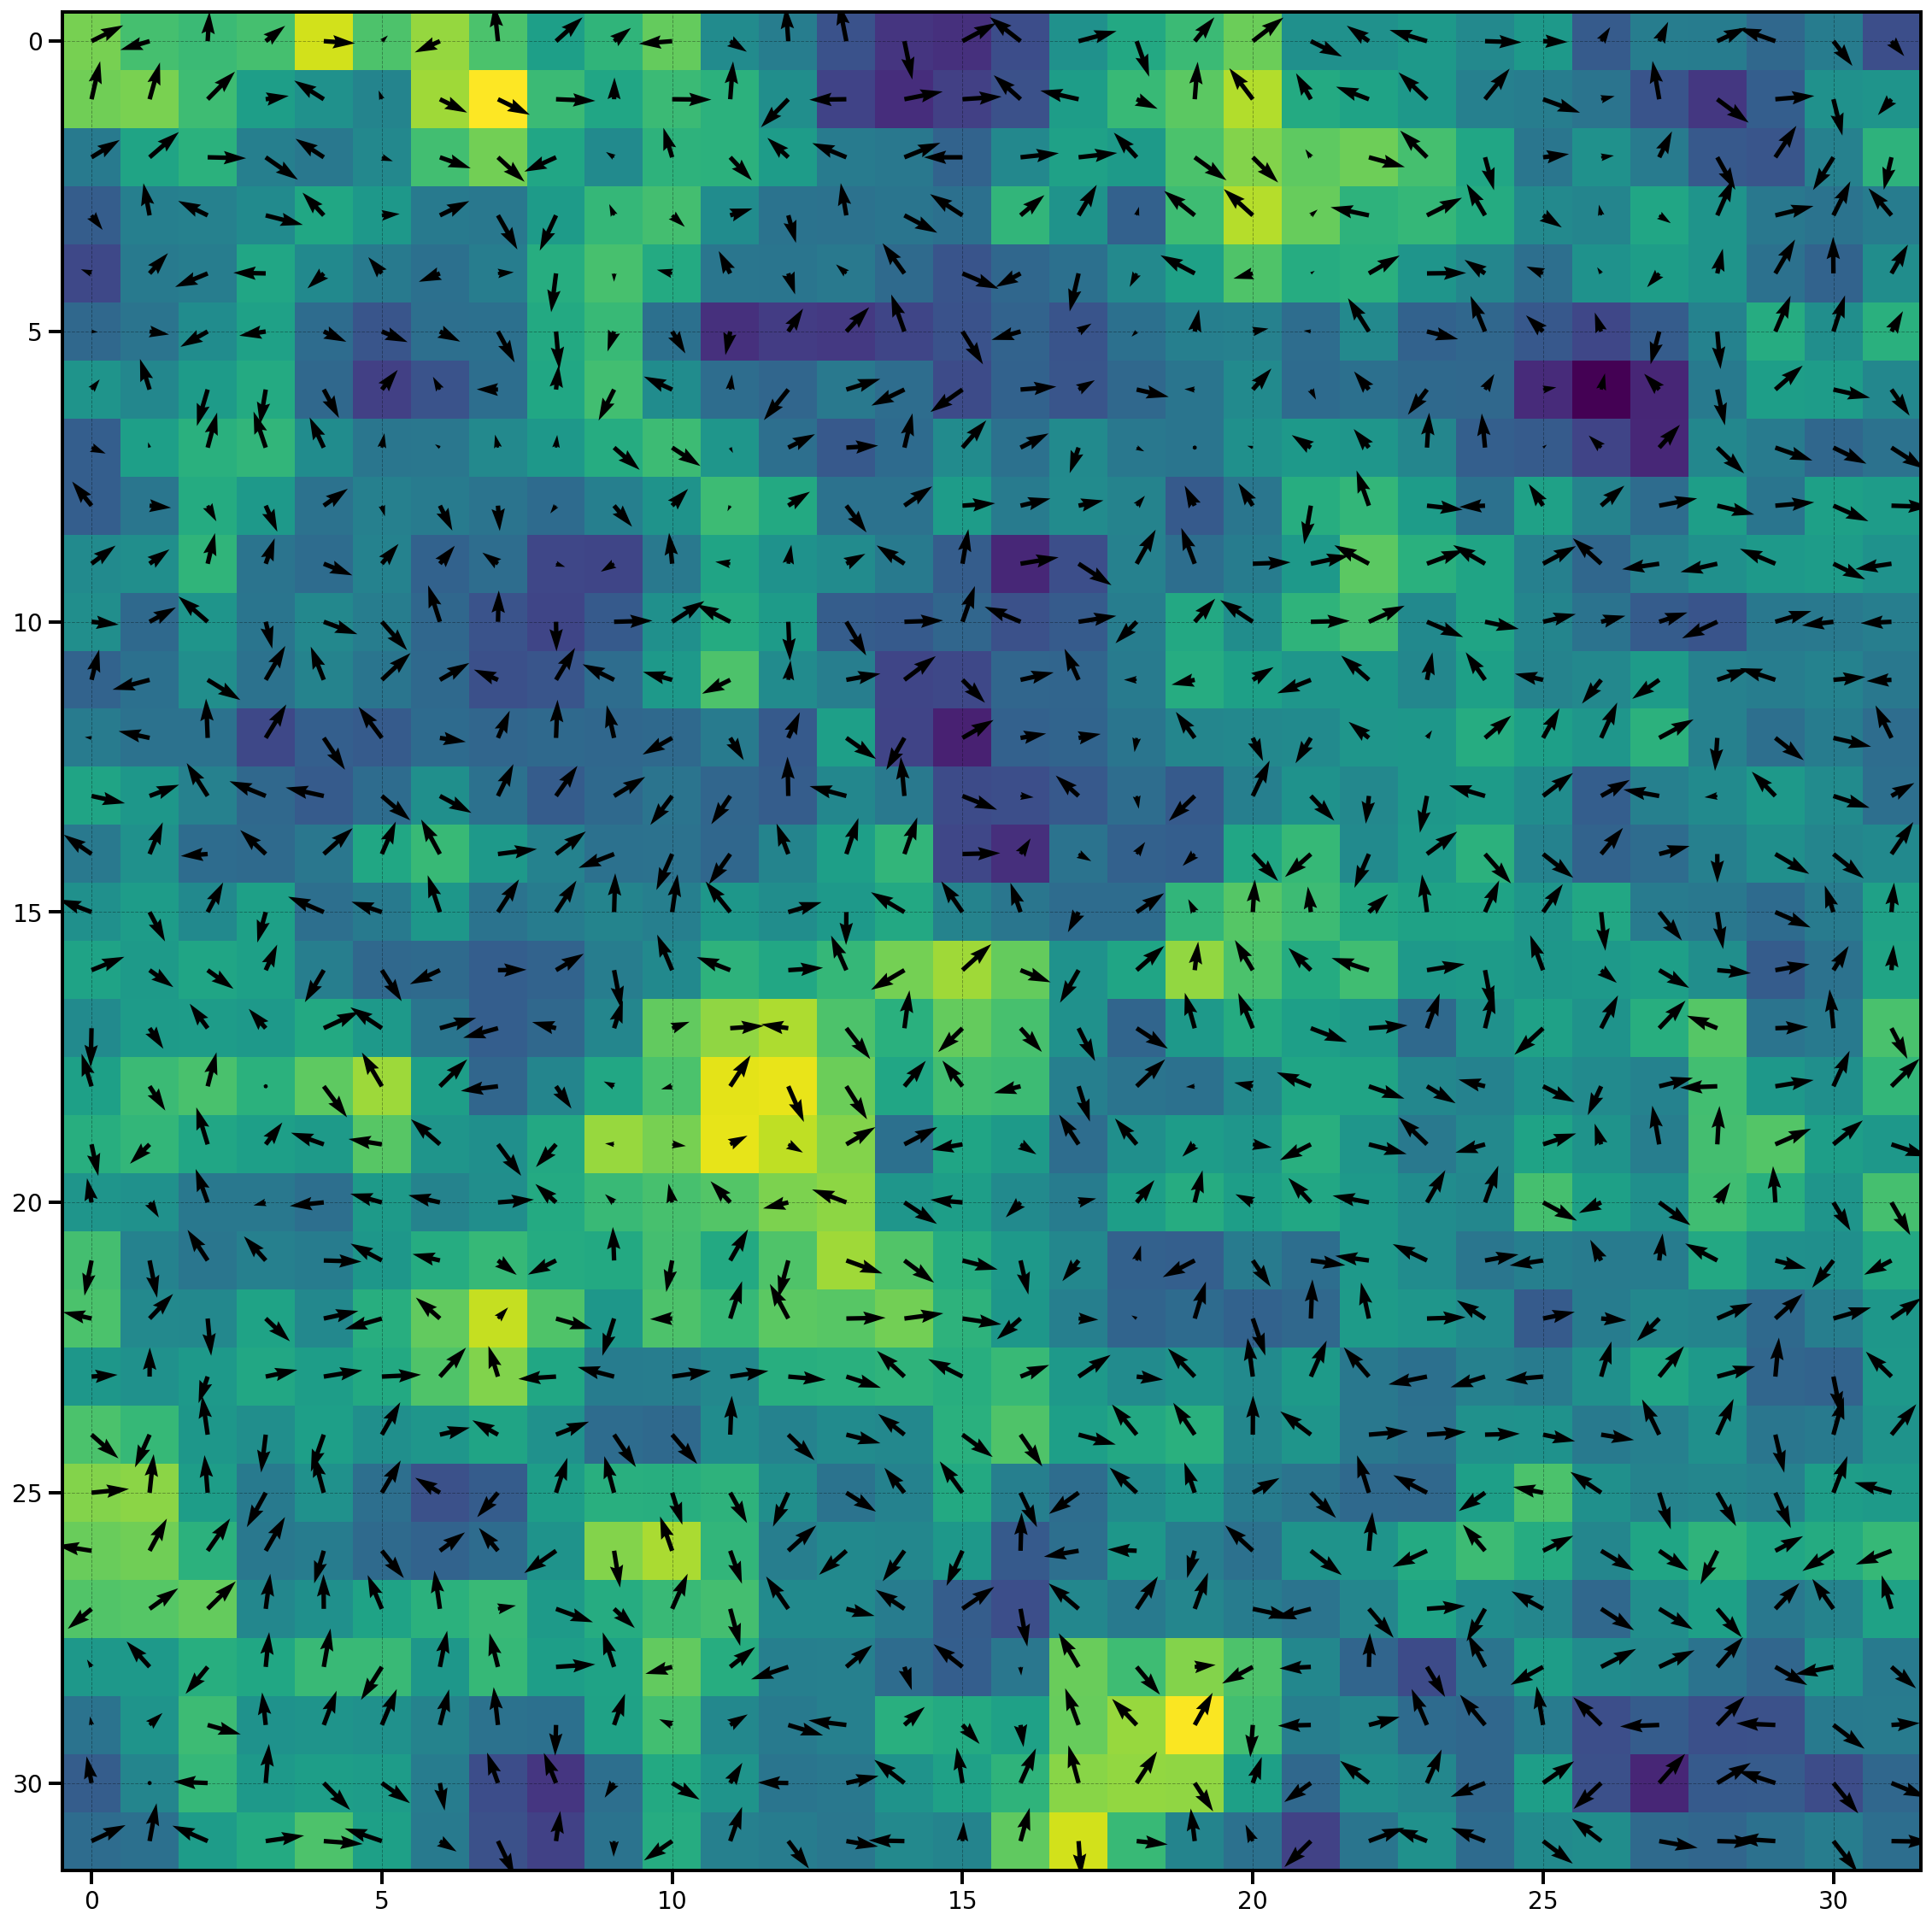

In [37]:
plt.figure(figsize = (20,20))

plt.quiver(
          vects[0,0:32,0:32,2,0],
          vects[0,0:32,0:32,2,1])
plt.imshow(one_plus_delta.preview(axes=[0,1])[0:32,0:32])
plt.show
